In [16]:
import numpy as np 
import numpy.random as npr
import networkx as nx
import matplotlib as plt
import plotly.graph_objects as go
import sys 
import graphviz

In [17]:
# variables

alpha = 0.8
beta = 0.2
u1 = 15
u2 = 75
thinkTime = 5000
timeSlice = 3
Sio1 = 40
Sio2 = 180
qio1 = 0.65 #route to io1
qio2 = 0.25 # route to io2
qoutd = 0.1*0.4 #go to delay station
qouts = 0.1*0.6 # renter the system

In [18]:
class State:
    def __init__(self,Ndelay, Ncpu, Nio1, Nio2,cpuStage = 0) -> None:
        self.Ndelay= Ndelay
        self.Ncpu = Ncpu
        self.Nio1 = Nio1 
        self.Nio2 = Nio2
        self.cpuStage = cpuStage
        pass

    def isValid(self)->bool:
        if self.Ncpu > 0:
            return (self.cpuStage == 1 or self.cpuStage == 2) and (self.Ncpu + self.Nio1 + self.Nio2 + self.Ndelay) == 3
        else:
            return (self.Ncpu + self.Nio1 + self.Nio2 + self.Ndelay) == 3
    
    def isAdjacent(self, node) -> bool:
        if node.Ncpu > 0:
            if node.cpuStage != self.cpuStage:
                if self.Ncpu < node.Ncpu and node.Ncpu !=0 and self.Ncpu != 0: return False 
                pass
            pass
        changes = 0
        def validChange(a1,a2):
            nonlocal changes
            if abs(a1-a2) > 0 and changes > 1:
                return False 
            elif abs(a1-a2) == 1:
                changes += 1
                return True 
            elif abs(a1-a2) >1:return False
            return True

        return validChange(self.Ncpu,node.Ncpu) and validChange(self.Ndelay,node.Ndelay) and validChange(self.Nio1,node.Nio1) and validChange(self.Nio2, node.Nio2)
        pass
    def __str__(self) -> str:
        return ("{},{},{},{}".format(
            self.Ndelay,
            self.Ncpu if self.Ncpu == 0 else "{}.{}".format(self.Ncpu,self.cpuStage),
            self.Nio1,
            self.Nio2
        ))
    pass


def stage_enumerator(stage: int) -> list[State]:
    Ndelay = 0
    Ncpu = 1
    Nio1 = 2
    Nio2 = 3
    cpuStage = stage
    stages = [0,0,0,0]
    result = []
    while stages[Ndelay] <= 3:
        for i in reversed(range(4)):
            stages[i] += 1
            if stages[i] <= 3: break
            elif i > 0 : stages[i] = 0
            pass
        state= State(stages[Ndelay], stages[Ncpu], stages[Nio1],stages[Nio2],stage)
        if state.isValid(): result.append(state)
        pass
    return result


print(list(map(lambda x: str(x),stage_enumerator(1))))
print(list(map(lambda x: str(x),stage_enumerator(2))))

s1 = State(3,0,0,0)
s2 = State(2,1,0,0,1)
assert(s1.isAdjacent(s2))

['0,0,0,3', '0,0,1,2', '0,0,2,1', '0,0,3,0', '0,1.1,0,2', '0,1.1,1,1', '0,1.1,2,0', '0,2.1,0,1', '0,2.1,1,0', '0,3.1,0,0', '1,0,0,2', '1,0,1,1', '1,0,2,0', '1,1.1,0,1', '1,1.1,1,0', '1,2.1,0,0', '2,0,0,1', '2,0,1,0', '2,1.1,0,0', '3,0,0,0']
['0,0,0,3', '0,0,1,2', '0,0,2,1', '0,0,3,0', '0,1.2,0,2', '0,1.2,1,1', '0,1.2,2,0', '0,2.2,0,1', '0,2.2,1,0', '0,3.2,0,0', '1,0,0,2', '1,0,1,1', '1,0,2,0', '1,1.2,0,1', '1,1.2,1,0', '1,2.2,0,0', '2,0,0,1', '2,0,1,0', '2,1.2,0,0', '3,0,0,0']


In [19]:
def edge_enumerator(stage: int) -> list[tuple[State,State]]:
    nodes = stage_enumerator(stage)
    result = []
    for head in nodes:
        for tail in nodes:
            if head != tail and head.isAdjacent(tail):
                result.append((head,tail))
                pass
            pass
        pass
    return result

print(list(map(lambda x:("{}->{}".format(str(x[0]), str(x[1]))),edge_enumerator(1))))
print(list(map(lambda x:("{}->{}".format(str(x[0]), str(x[1]))),edge_enumerator(2))))

['0,0,0,3->0,0,1,2', '0,0,0,3->0,1.1,0,2', '0,0,0,3->1,0,0,2', '0,0,1,2->0,0,0,3', '0,0,1,2->0,0,2,1', '0,0,1,2->0,1.1,0,2', '0,0,1,2->0,1.1,1,1', '0,0,1,2->1,0,0,2', '0,0,1,2->1,0,1,1', '0,0,2,1->0,0,1,2', '0,0,2,1->0,0,3,0', '0,0,2,1->0,1.1,1,1', '0,0,2,1->0,1.1,2,0', '0,0,2,1->1,0,1,1', '0,0,2,1->1,0,2,0', '0,0,3,0->0,0,2,1', '0,0,3,0->0,1.1,2,0', '0,0,3,0->1,0,2,0', '0,1.1,0,2->0,0,0,3', '0,1.1,0,2->0,0,1,2', '0,1.1,0,2->0,1.1,1,1', '0,1.1,0,2->0,2.1,0,1', '0,1.1,0,2->1,0,0,2', '0,1.1,0,2->1,1.1,0,1', '0,1.1,1,1->0,0,1,2', '0,1.1,1,1->0,0,2,1', '0,1.1,1,1->0,1.1,0,2', '0,1.1,1,1->0,1.1,2,0', '0,1.1,1,1->0,2.1,0,1', '0,1.1,1,1->0,2.1,1,0', '0,1.1,1,1->1,0,1,1', '0,1.1,1,1->1,1.1,0,1', '0,1.1,1,1->1,1.1,1,0', '0,1.1,2,0->0,0,2,1', '0,1.1,2,0->0,0,3,0', '0,1.1,2,0->0,1.1,1,1', '0,1.1,2,0->0,2.1,1,0', '0,1.1,2,0->1,0,2,0', '0,1.1,2,0->1,1.1,1,0', '0,2.1,0,1->0,1.1,0,2', '0,2.1,0,1->0,1.1,1,1', '0,2.1,0,1->0,2.1,1,0', '0,2.1,0,1->0,3.1,0,0', '0,2.1,0,1->1,1.1,0,1', '0,2.1,0,1->1,2.1,0,0

In [20]:


class DiGraph():
   
   def __init__(self):
     self.graph = nx.digraph.DiGraph()
     self.viz = graphviz.Digraph()
     self.lastHead = ""
     self.lastTail = ""
     self.calls = 0
     pass

   def gen(self,headLabel, tailLabel, p):
    if (headLabel,tailLabel) in self.graph.edges:
      print("Warning redundant edge {} , {} , call N {}".format(headLabel,tailLabel,self.calls))
      pass
    if headLabel not in self.graph.nodes:
      print("Warning head {} not listed".format(headLabel))
      pass
    if tailLabel not in self.graph.nodes:
      print("Warning tail {} not listed".format(tailLabel))
      pass
    self.lastHead = headLabel
    self.lastTail = tailLabel 
    self.graph.add_edge(headLabel,tailLabel,weight=round(p,5))
    return (headLabel,tailLabel)

   def Graph(self):
     return self.graph
   
   
   def __and__(self,arg:tuple[str,str,float]):
     return self.gen(arg[0],arg[1],arg[2])
  
   
   def __getitem__(self,index):
     return self.graph.edges()[index]
   
   def add_edge(self,head,tail,p):
     self.gen(head() if callable(head) else head, tail() if callable(tail) else tail, p)
     pass


   
   def __call__(self, head,tail,pout,pin =0):
     if callable(head): 
       head = head()
       pass
     if callable(tail):
       tail = tail()
       pass
     self.add_edge(head,tail,pout)
     if pin > 0:
      self.add_edge(tail,head,pin)
      pass
     self.calls += 1
     return self
   
   def add_edges(self,edges: list[tuple]):
     for edge in edges:
       head = ""
       tail = ""
       if callable(edge[0]): head = edge[0]()
       else: head=edge[0]
       if callable(edge[1]): tail = edge[1]()
       else: tail = edge[1]
       self.gen(head,tail,edge[2])
       pass
     pass
   
   def add_node(self,node:str):
     self.graph.add_node(node)
     pass
   
   
   def last_tail(self): return self.lastTail
   def last_head(self) : return self.lastHead

   def gviz(self):
      graph = graphviz.Digraph()
      for node in self.graph.nodes:
        graph.node(node)
        pass
      for edge in self.graph.edges:
       graph.edge(edge[0],edge[1],str(self.graph.get_edge_data(edge[0],edge[1])["weight"]))
       pass
      return graph
   
   def fig(self):
     pos = nx.draw_planar(self.graph)
     fig = nx.draw_networkx_nodes(self.graph,pos,node_size=1000)
     fig = nx.draw_networkx_labels(self.graph,pos)
     fig = nx.draw_networkx_edges(self.graph,pos)
     fig = nx.draw_networkx_edge_labels(self.graph,pos)
     pass
   pass

   



legend (Delay_station,CPU.Stage,IO1,IO2)


Warning redundant edge 0,1.2,2,0 , 0,0,3,0 , call N 35


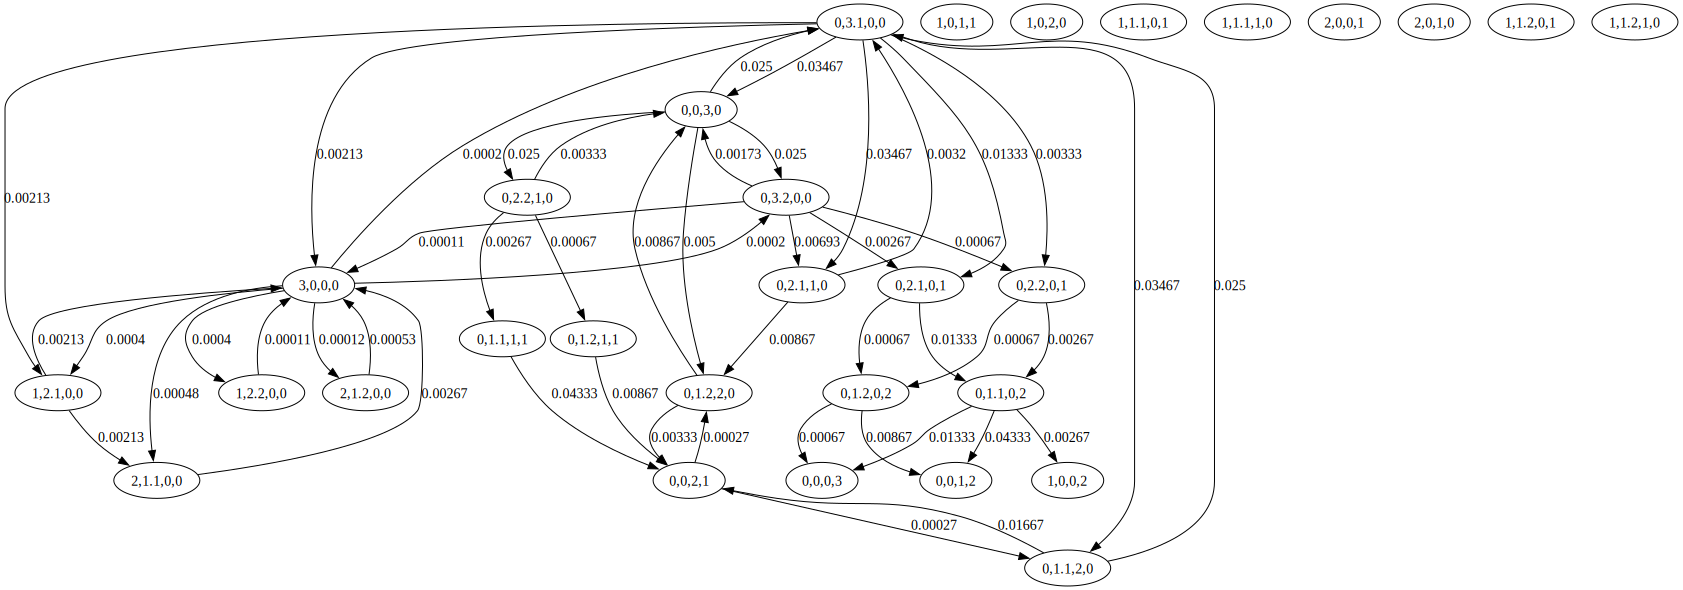

In [21]:
chain = DiGraph()

nodes = list(map(lambda x:str(x),stage_enumerator(1) + stage_enumerator(2)))
edges = edge_enumerator(1) + edge_enumerator(2)

for node in nodes:
    chain.add_node(node)
    pass

for edge in edges:
    chain.add_edge(str(edge[0]),str(edge[1]),0)
    pass

(chain
("3,0,0,0","2,1.1,0,0",(1/thinkTime)*alpha*3, (1/u1)*qoutd)
(chain.last_tail,"1,2.1,0,0",(1/thinkTime)*2,(1/u1)*qoutd*alpha)
(chain.last_tail,"0,3.1,0,0",(1/thinkTime),(1/u1)*qoutd*alpha)
("3,0,0,0","2,1.2,0,0",(1/thinkTime)*beta*3,(1/u2)*qoutd)
(chain.last_tail,"1,2.2,0,0",(1/thinkTime)*2,(1/u2)*beta*qoutd)
(chain.last_tail,"0,3.2,0,0",(1/thinkTime),(1/u2)*beta*qoutd)
("0,3.1,0,0","0,2.1,1,0", (1/u1)*alpha*qio1,(1/u1)*alpha*qouts) 
(chain.last_tail, "0,1.1,2,0", (1/u1)*alpha*qio1,(1/Sio1))
(chain.last_tail, "0,0,3,0",(1/u1)*alpha*qio1,(1/Sio1))
("0,0,3,0","0,1.2,2,0",(1/Sio1)*beta,(1/u2)*qio1)
(chain.last_tail,"0,2.2,1,0",(1/Sio1),(1/u2)*qio2)
(chain.last_tail, "0,3.2,0,0",(1/Sio1),(1/u2)*qio1*beta)
("0,3.2,0,0","0,2.1,1,0",(1/u2)*alpha*qio1)
(chain.last_tail,"0,1.2,2,0",(1/u1)*beta*qio1)
("0,3.1,0,0","0,2.1,0,1",(1/u1)*alpha*qio2)
(chain.last_tail,"0,1.1,0,2",(1/u1)*alpha*qio2)
(chain.last_tail,"0,0,0,3",(1/u1)*alpha*qio2)
("0,3.2,0,0","0,2.2,0,1",(1/u2)*beta*qio2)
(chain.last_tail,"0,1.2,0,2",(1/u2)*beta*qio2)
(chain.last_tail,"0,0,0,3",(1/u2)*beta*qio2)
("0,3.2,0,0","0,2.1,0,1",(1/u2)*alpha*qio2)
(chain.last_tail,"0,1.2,0,2",(1/u2)*beta*qio2)
("0,3.1,0,0","0,2.2,0,1",(1/u1)*beta*qio2)
(chain.last_tail,"0,1.1,0,2",(1/u2)*alpha*qio2)
("0,1.1,0,2","0,0,1,2",(1/u1)*qio1)
("0,1.2,0,2","0,0,1,2",(1/u2)*qio1)
("0,1.1,2,0","0,0,2,1",(1/u1)*qio2)
("0,1.2,2,0","0,0,2,1",(1/u2)*qio2)
("0,2.2,1,0","0,1.2,1,1",(1/u2)*beta*qio2)
("0,2.2,1,0","0,1.1,1,1", (1/u2)*alpha*qio2)
("0,1.1,1,1","0,0,2,1",(1/u1)*qio1)
("0,1.2,1,1","0,0,2,1",(1/u2)*qio1)
("0,1.1,0,2","1,0,0,2",(1/u1)*qoutd)
("1,2.1,0,0","2,1.1,0,0",(1/u1)*alpha*qoutd)
("0,3.1,0,0","1,2.1,0,0",(1/u1)*alpha*qoutd)
("0,1.2,2,0","0,0,3,0",(1/u2)*qio1)
("0,0,2,1","0,1.1,2,0",(1/Sio2)*alpha*qouts)
("0,0,2,1","0,1.2,2,0",(1/Sio2)*qouts*alpha)
)

chain.gviz()